# Step 3 : **Perspective Transformation**

**Apply a perspective transform to rectify binary image ("birds-eye view").**

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

**Camera Calibration**

In [2]:
# Read in the saved camera matrix and distortion coefficients
cameraCalibrationImgs = pickle.load( open( "Camera_Calibration.p", "rb" ) )
mtx = cameraCalibrationImgs["mtx"]
dist = cameraCalibrationImgs["dist"]

In [3]:
! unzip test_images

Archive:  test_images.zip
  inflating: test_images/straight_lines1.jpg  
  inflating: test_images/straight_lines2.jpg  
  inflating: test_images/test1.jpg   
  inflating: test_images/test2.jpg   
  inflating: test_images/test3.jpg   
  inflating: test_images/test4.jpg   
  inflating: test_images/test5.jpg   
  inflating: test_images/test6.jpg   


In [4]:
# Load test images using glob.
# read test images using cv2.imread .
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('test_images/st*.jpg')))

In [5]:
# convert test images to RGB to show
Test_imgsToShow = []
for fname in testImages:
    fileName, img = fname
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    Test_imgsToShow.append(img)

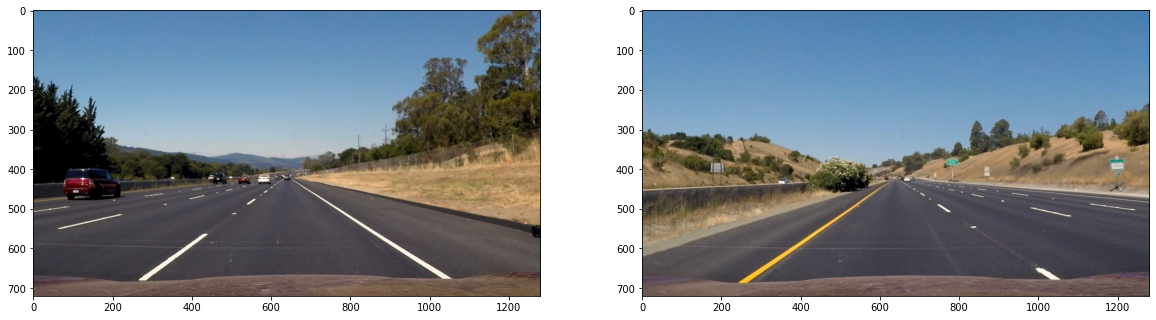

In [6]:
def show_image(images):
    n: int = len(images)
    f = plt.figure(figsize=(20,10))
    for i in range(n):
        f.add_subplot(1,2, i + 1)
        plt.imshow(images[i])

show_image(Test_imgsToShow)
# plt.savefig("straight_lines_imgsTest.png")

**Undistort**


In [7]:
def cal_undistort(img, mtx, dist) :

  """
  Undistort the image with `mtx`, `dist`.

  """
  #Undistorting a test image:
  undist = cv2.undistort(img, mtx, dist, None, mtx)

  return undist

In [8]:
# apply cal_undistort function to testimages and pask the images in a list 
Undist_images = []
for fname in testImages:
    fileName, img = fname
    Undist = cal_undistort(img, mtx, dist)
    Undist_images.append(Undist)

In [9]:
def unwarp(img):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32(
    [[(img_size[0] / 2) - 62, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 62), img_size[1] / 2 + 100]])

    #print(src)

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    #print(dst)
        
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M,img_size , flags=cv2.INTER_LINEAR)

    return warped

In [10]:
# apply abs_sobel_thresh function to UndistHLS_images and pask the images in a list to show
Undistorted_Warped_imgs = []

for img in Undist_images:
  Warped_imgs = unwarp(img)
  Undistorted_Warped_imgs.append(Warped_imgs)


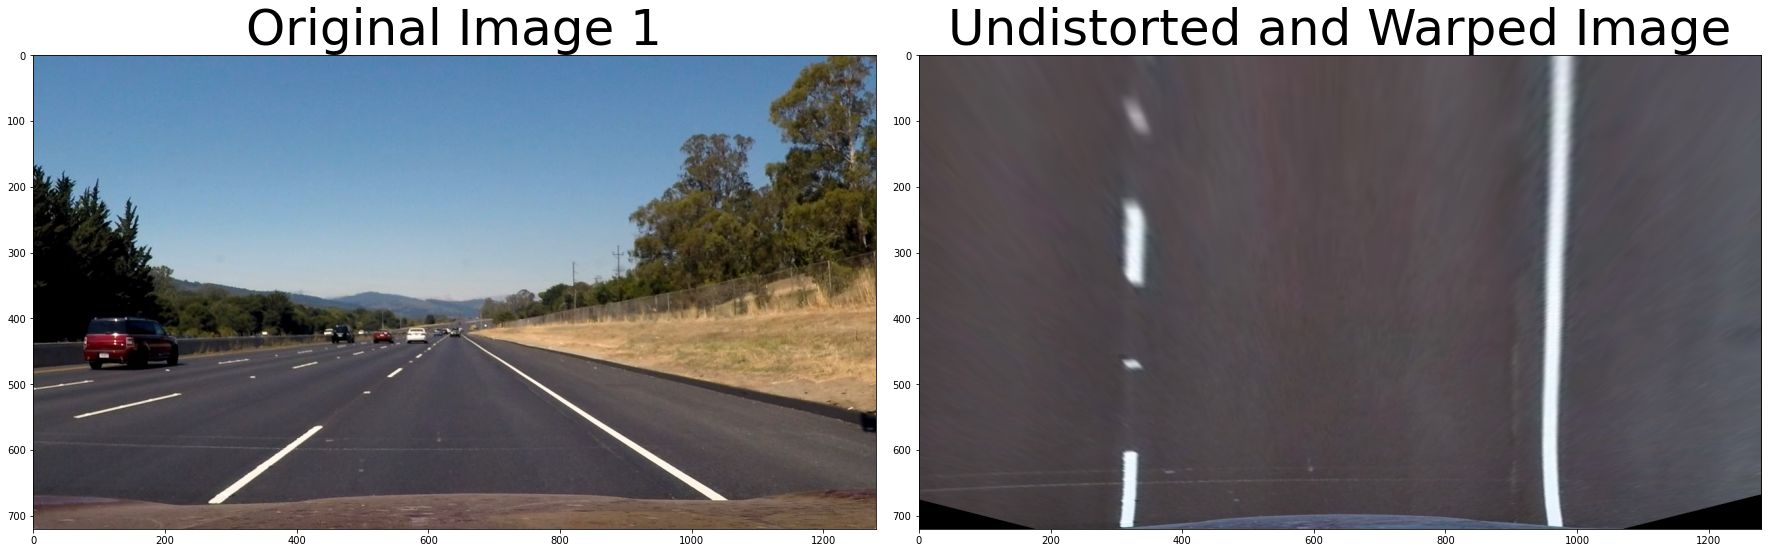

In [11]:
# the first warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Test_imgsToShow[0])
ax1.set_title('Original Image 1', fontsize=50)
ax2.imshow(Undistorted_Warped_imgs[0])
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("Undistorted_ Warped.png")

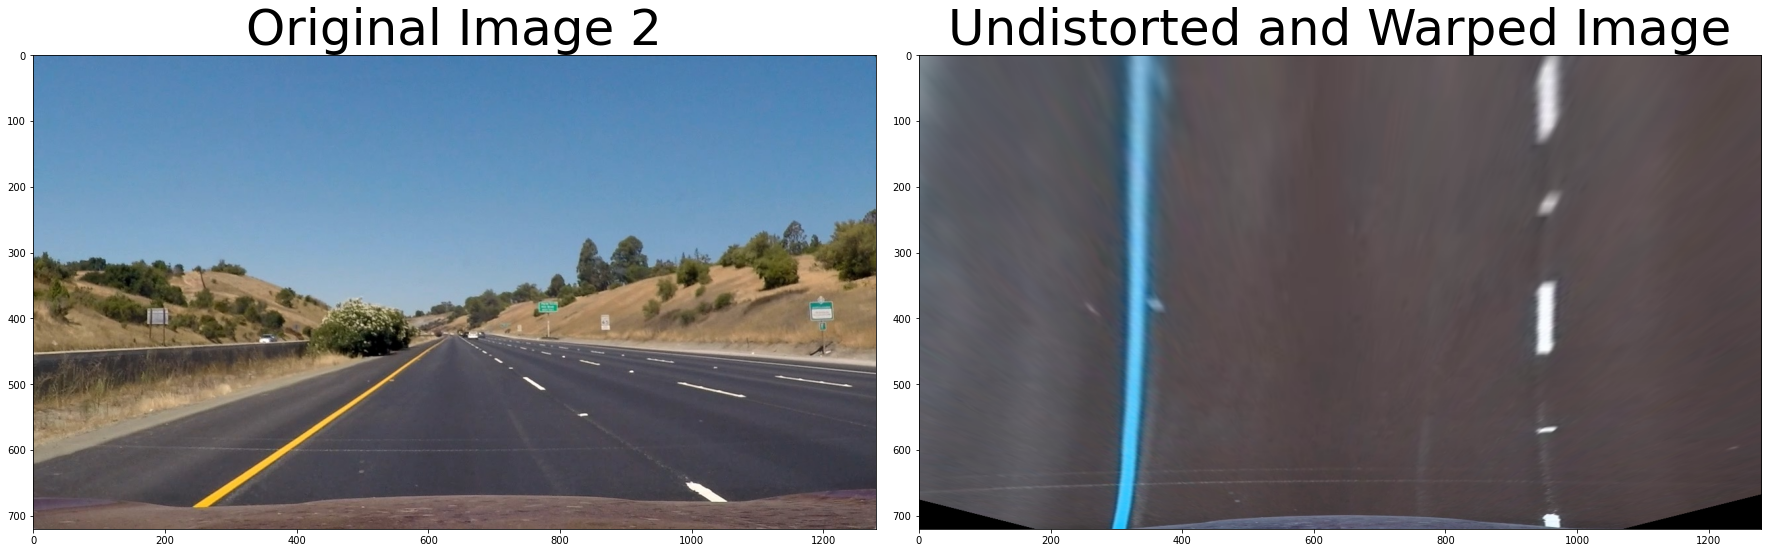

In [12]:
# the second warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(Test_imgsToShow[1])
ax1.set_title('Original Image 2', fontsize=50)
ax2.imshow(Undistorted_Warped_imgs[1])
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Step 3 :  **Finding the Lines: Histogram Peaks**


In [13]:
Undistorted_Warped_imgs[1].shape

(720, 1280, 3)

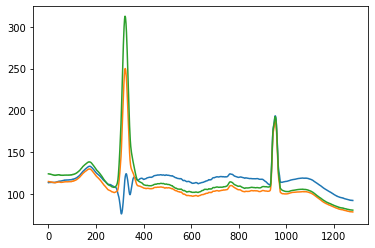

In [14]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = Undistorted_Warped_imgs[1]/255


def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)
# plt.savefig("hist-of-binary-image.png")

In [15]:
def hls_select(img, thresh=(0, 255)):

    '''
    This function thresholds the S-channel of HLS

    '''
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [17]:
# Load our image
binary_warped = hls_select(Undistorted_Warped_imgs[1])
binary_warped = cv2.cvtColor(Undistorted_Warped_imgs[0], cv2.COLOR_RGB2GRAY)

In [18]:
binary_warped.shape

(720, 1280)

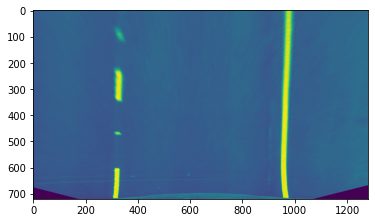

In [22]:
plt.imshow(binary_warped)